In [1]:
import os
import logging
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset, Dataset
from sentence_transformers import SentenceTransformer, InputExample, losses
from sentence_transformers.evaluation import InformationRetrievalEvaluator
from torch.utils.data import DataLoader
from huggingface_hub import login

logging.basicConfig(format='%(asctime)s - %(message)s', datefmt='%Y-%m-%d %H:%M:%S', level=logging.INFO)

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)


dataset = load_dataset("sentence-transformers/natural-questions", split="train")
print(f"Full dataset size: {len(dataset)}")

dataset = dataset.select(range(5000))
print(f"Using subset with {len(dataset)} examples")

train_test_split = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = train_test_split["train"]
rest_dataset = train_test_split["test"]
val_test_split = rest_dataset.train_test_split(test_size=0.5, seed=42)
val_dataset = val_test_split["train"]
test_dataset = val_test_split["test"]

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

sample = train_dataset[0]
print("\nSample from the dataset:")
print(f"Query: {sample['query']}")
print(f"Answer: {sample['answer']}")




Loading Natural Questions dataset...


README.md:   0%|          | 0.00/2.28k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
2025-05-20 09:47:43 - Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


train-00000-of-00001.parquet:   0%|          | 0.00/44.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/100231 [00:00<?, ? examples/s]

Full dataset size: 100231
Using subset with 5000 examples
Train dataset size: 4000
Validation dataset size: 500
Test dataset size: 500

Sample from the dataset:
Query: when did the temporary foreign worker program start
Answer: Temporary foreign worker program in Canada The Temporary foreign worker program or TFWP is a program of the Government of Canada to allow employers in Canada to hire foreign nationals.[1] When the program started in 1973, most of the workers brought in were high-skill workers such as specialist doctors.[2] In 2002 a "low-skilled workers" category was added; this category now makes up most of the temporary foreign workforce.[2][3] In 2006, the program was expanded and fast-tracking introduced for some locations.[2] It was revised again in 2013, raising wages, charging employer fees, and removing the accelerated applications.[4]


In [ ]:
# Evaluate the Base Model (Before Fine-tuning)

print("\nLoading base embedding model...")
base_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
print(f"Base model loaded with dimension: {base_model.get_sentence_embedding_dimension()}")

print("\nPreparing validation data for evaluation...")

corpus = {}
for idx, example in enumerate(val_dataset):
    corpus[str(idx)] = example["answer"]

queries = {}
for idx, example in enumerate(val_dataset):
    queries[str(idx)] = example["query"]


relevance = {}
for idx in range(len(val_dataset)):
    relevance[str(idx)] = {str(idx): 1}  # Mark corpus item with same ID as relevant

print("\nSetting up evaluator...")
evaluator = InformationRetrievalEvaluator(
    queries=queries,
    corpus=corpus,
    relevant_docs=relevance,
    name="nq-val",
    show_progress_bar=True,
    batch_size=16,
    corpus_chunk_size=100
)

2025-05-20 09:47:52 - Use pytorch device_name: cuda:0
2025-05-20 09:47:52 - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2



Loading base embedding model...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
2025-05-20 09:47:54 - Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Base model loaded with dimension: 384

Preparing validation data for evaluation...

Setting up evaluator...


In [3]:
print("\nEvaluating base model...")
base_results = evaluator(base_model)

print("\nBase model evaluation results:")
for metric, value in base_results.items():
    print(f"{metric}: {value:.4f}")

if 'ndcg_at_10' in base_results:
    base_ndcg10 = base_results['ndcg_at_10']
    print(f"Using NDCG@10 for comparison: {base_ndcg10:.4f}")
elif 'ndcg@10' in base_results:
    base_ndcg10 = base_results['ndcg@10']
    print(f"Using NDCG@10 for comparison: {base_ndcg10:.4f}")
else:
    ndcg_metrics = [m for m in base_results.keys() if 'ndcg' in m.lower()]
    if ndcg_metrics:
        ndcg_metric = ndcg_metrics[0]
        base_ndcg10 = base_results[ndcg_metric]
        print(f"No NDCG@10 found. Using {ndcg_metric} for comparison: {base_ndcg10:.4f}")
    else:
        base_ndcg10 = 0.0
        print("No NDCG metrics found in evaluation results.")

2025-05-20 09:48:22 - Information Retrieval Evaluation of the model on the nq-val dataset:



Evaluating base model...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Corpus Chunks:  20%|██        | 1/5 [00:00<00:00,  8.64it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Corpus Chunks:  40%|████      | 2/5 [00:00<00:00,  8.86it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Corpus Chunks:  60%|██████    | 3/5 [00:00<00:00,  8.85it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Corpus Chunks:  80%|████████  | 4/5 [00:00<00:00,  8.77it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 5/5 [00:00<00:00,  8.75it/s]
2025-05-20 09:48:23 - Queries: 500
2025-05-20 09:48:23 - Corpus: 500

2025-05-20 09:48:23 - Score-Function: cosine
2025-05-20 09:48:23 - Accuracy@1: 97.00%
2025-05-20 09:48:23 - Accuracy@3: 99.80%
2025-05-20 09:48:23 - Accuracy@5: 99.80%
2025-05-20 09:48:23 - Accuracy@10: 100.00%
2025-05-20 09:48:23 - Precision@1: 97.00%
2025-05-20 09:48:23 - Precision@3: 33.27%
2025-05-20 09:48:23 - Precision@5: 19.96%
2025-05-20 09:48:23 - Precision@10: 10.00%
2025-05-20 09:48:23 - Recall@1: 97.00%
2025-05-20 09:48:23 - Recall@3: 99.80%
2025-05-20 09:48:23 - Recall@5: 99.80%
2025-05-20 09:48:23 - Recall@10: 100.00%
2025-05-20 09:48:23 - MRR@10: 0.9843
2025-05-20 09:48:23 - NDCG@10: 0.9884
2025-05-20 09:48:23 - MAP@100: 0.9843



Base model evaluation results:
nq-val_cosine_accuracy@1: 0.9700
nq-val_cosine_accuracy@3: 0.9980
nq-val_cosine_accuracy@5: 0.9980
nq-val_cosine_accuracy@10: 1.0000
nq-val_cosine_precision@1: 0.9700
nq-val_cosine_precision@3: 0.3327
nq-val_cosine_precision@5: 0.1996
nq-val_cosine_precision@10: 0.1000
nq-val_cosine_recall@1: 0.9700
nq-val_cosine_recall@3: 0.9980
nq-val_cosine_recall@5: 0.9980
nq-val_cosine_recall@10: 1.0000
nq-val_cosine_ndcg@10: 0.9884
nq-val_cosine_mrr@10: 0.9843
nq-val_cosine_map@100: 0.9843
No NDCG@10 found. Using nq-val_cosine_ndcg@10 for comparison: 0.9884


In [4]:
## Prepare Training Data for Fine-tuning

# pairs of queries and relevant documents
print("\nPreparing training examples...")

train_examples = []
for example in train_dataset:
    # Each query-answer pair is a positive example
    train_examples.append(InputExample(
        texts=[example["query"], example["answer"]],
        label=1.0  # Label is not used for MultipleNegativesRankingLoss but good to include
    ))

# Create a data loader
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)
print(f"Created {len(train_examples)} training examples")



Preparing training examples...
Created 4000 training examples


In [5]:
## Fine-tune the Model

print("\nInitializing model for fine-tuning...")
model_name = "sentence-transformers/all-MiniLM-L6-v2"  # A good starting point
model = SentenceTransformer(model_name)

print("\nSetting up loss function...")
train_loss = losses.MultipleNegativesRankingLoss(model)

print("\nStarting training...")
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=3,
    evaluation_steps=500,
    evaluator=evaluator,
    output_path="./models/fine-tuned-embeddings-nq",
    save_best_model=True,
    show_progress_bar=True,
    warmup_steps=100
)

model.save("./models/fine-tuned-embeddings-nq/final")
print("\nFine-tuned model saved to './models/fine-tuned-embeddings-nq/final'")

# aa5c27b24d637f82028e2668ad2b2a73dd2fa22c

2025-05-20 09:49:52 - Use pytorch device_name: cuda:0
2025-05-20 09:49:52 - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2



Initializing model for fine-tuning...

Setting up loss function...

Starting training...


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

  ········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: bavanasreevaatsav1 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Nq-val Cosine Accuracy@1,Nq-val Cosine Accuracy@3,Nq-val Cosine Accuracy@5,Nq-val Cosine Accuracy@10,Nq-val Cosine Precision@1,Nq-val Cosine Precision@3,Nq-val Cosine Precision@5,Nq-val Cosine Precision@10,Nq-val Cosine Recall@1,Nq-val Cosine Recall@3,Nq-val Cosine Recall@5,Nq-val Cosine Recall@10,Nq-val Cosine Ndcg@10,Nq-val Cosine Mrr@10,Nq-val Cosine Map@100
250,No log,No log,0.976000,0.998000,1.000000,1.000000,0.976000,0.332667,0.200000,0.100000,0.976000,0.998000,1.000000,1.000000,0.990480,0.987167,0.987167
500,0.006900,No log,0.970000,0.996000,1.000000,1.000000,0.970000,0.332000,0.200000,0.100000,0.970000,0.996000,1.000000,1.000000,0.988127,0.984000,0.984000
750,0.006900,No log,0.974000,0.998000,1.000000,1.000000,0.974000,0.332667,0.200000,0.100000,0.974000,0.998000,1.000000,1.000000,0.990004,0.986500,0.986500


2025-05-20 09:51:38 - Information Retrieval Evaluation of the model on the nq-val dataset in epoch 1.0 after 250 steps:


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Corpus Chunks:  20%|██        | 1/5 [00:00<00:00,  8.20it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Corpus Chunks:  40%|████      | 2/5 [00:00<00:00,  8.19it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Corpus Chunks:  60%|██████    | 3/5 [00:00<00:00,  8.22it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Corpus Chunks:  80%|████████  | 4/5 [00:00<00:00,  8.26it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 5/5 [00:00<00:00,  8.29it/s]
2025-05-20 09:51:39 - Queries: 500
2025-05-20 09:51:39 - Corpus: 500

2025-05-20 09:51:39 - Score-Function: cosine
2025-05-20 09:51:39 - Accuracy@1: 97.60%
2025-05-20 09:51:39 - Accuracy@3: 99.80%
2025-05-20 09:51:39 - Accuracy@5: 100.00%
2025-05-20 09:51:39 - Accuracy@10: 100.00%
2025-05-20 09:51:39 - Precision@1: 97.60%
2025-05-20 09:51:39 - Precision@3: 33.27%
2025-05-20 09:51:39 - Precision@5: 20.00%
2025-05-20 09:51:39 - Precision@10: 10.00%
2025-05-20 09:51:39 - Recall@1: 97.60%
2025-05-20 09:51:39 - Recall@3: 99.80%
2025-05-20 09:51:39 - Recall@5: 100.00%
2025-05-20 09:51:39 - Recall@10: 100.00%
2025-05-20 09:51:39 - MRR@10: 0.9872
2025-05-20 09:51:39 - NDCG@10: 0.9905
2025-05-20 09:51:39 - MAP@100: 0.9872
2025-05-20 09:51:39 - Save model to ./models/fine-tuned-embeddings-nq
2025-05-20 09:52:05 - Information Retrieval Evaluation of the model on the nq-val dataset in epoch 2.0 after 500 steps:


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Corpus Chunks:  20%|██        | 1/5 [00:00<00:00,  7.54it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Corpus Chunks:  40%|████      | 2/5 [00:00<00:00,  7.42it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Corpus Chunks:  60%|██████    | 3/5 [00:00<00:00,  7.41it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Corpus Chunks:  80%|████████  | 4/5 [00:00<00:00,  7.43it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 5/5 [00:00<00:00,  7.44it/s]
2025-05-20 09:52:06 - Queries: 500
2025-05-20 09:52:06 - Corpus: 500

2025-05-20 09:52:06 - Score-Function: cosine
2025-05-20 09:52:06 - Accuracy@1: 97.00%
2025-05-20 09:52:06 - Accuracy@3: 99.60%
2025-05-20 09:52:06 - Accuracy@5: 100.00%
2025-05-20 09:52:06 - Accuracy@10: 100.00%
2025-05-20 09:52:06 - Precision@1: 97.00%
2025-05-20 09:52:06 - Precision@3: 33.20%
2025-05-20 09:52:06 - Precision@5: 20.00%
2025-05-20 09:52:06 - Precision@10: 10.00%
2025-05-20 09:52:06 - Recall@1: 97.00%
2025-05-20 09:52:06 - Recall@3: 99.60%
2025-05-20 09:52:06 - Recall@5: 100.00%
2025-05-20 09:52:06 - Recall@10: 100.00%
2025-05-20 09:52:06 - MRR@10: 0.9840
2025-05-20 09:52:06 - NDCG@10: 0.9881
2025-05-20 09:52:06 - MAP@100: 0.9840
2025-05-20 09:52:06 - Information Retrieval Evaluation of the model on the nq-val dataset in epoch 2.0 after 500 steps:


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Corpus Chunks:  20%|██        | 1/5 [00:00<00:00,  7.63it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Corpus Chunks:  40%|████      | 2/5 [00:00<00:00,  7.65it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Corpus Chunks:  60%|██████    | 3/5 [00:00<00:00,  7.61it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Corpus Chunks:  80%|████████  | 4/5 [00:00<00:00,  7.50it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 5/5 [00:00<00:00,  7.57it/s]
2025-05-20 09:52:07 - Queries: 500
2025-05-20 09:52:07 - Corpus: 500

2025-05-20 09:52:07 - Score-Function: cosine
2025-05-20 09:52:07 - Accuracy@1: 97.00%
2025-05-20 09:52:07 - Accuracy@3: 99.60%
2025-05-20 09:52:07 - Accuracy@5: 100.00%
2025-05-20 09:52:07 - Accuracy@10: 100.00%
2025-05-20 09:52:07 - Precision@1: 97.00%
2025-05-20 09:52:07 - Precision@3: 33.20%
2025-05-20 09:52:07 - Precision@5: 20.00%
2025-05-20 09:52:07 - Precision@10: 10.00%
2025-05-20 09:52:07 - Recall@1: 97.00%
2025-05-20 09:52:07 - Recall@3: 99.60%
2025-05-20 09:52:07 - Recall@5: 100.00%
2025-05-20 09:52:07 - Recall@10: 100.00%
2025-05-20 09:52:07 - MRR@10: 0.9840
2025-05-20 09:52:07 - NDCG@10: 0.9881
2025-05-20 09:52:08 - MAP@100: 0.9840
2025-05-20 09:52:33 - Information Retrieval Evaluation of the model on the nq-val dataset in epoch 3.0 after 750 steps:


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Corpus Chunks:  20%|██        | 1/5 [00:00<00:00,  7.51it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Corpus Chunks:  40%|████      | 2/5 [00:00<00:00,  7.47it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Corpus Chunks:  60%|██████    | 3/5 [00:00<00:00,  7.48it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Corpus Chunks:  80%|████████  | 4/5 [00:00<00:00,  7.37it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 5/5 [00:00<00:00,  7.53it/s]
2025-05-20 09:52:34 - Queries: 500
2025-05-20 09:52:34 - Corpus: 500

2025-05-20 09:52:34 - Score-Function: cosine
2025-05-20 09:52:34 - Accuracy@1: 97.40%
2025-05-20 09:52:34 - Accuracy@3: 99.80%
2025-05-20 09:52:34 - Accuracy@5: 100.00%
2025-05-20 09:52:34 - Accuracy@10: 100.00%
2025-05-20 09:52:34 - Precision@1: 97.40%
2025-05-20 09:52:34 - Precision@3: 33.27%
2025-05-20 09:52:34 - Precision@5: 20.00%
2025-05-20 09:52:34 - Precision@10: 10.00%
2025-05-20 09:52:34 - Recall@1: 97.40%
2025-05-20 09:52:34 - Recall@3: 99.80%
2025-05-20 09:52:34 - Recall@5: 100.00%
2025-05-20 09:52:34 - Recall@10: 100.00%
2025-05-20 09:52:34 - MRR@10: 0.9865
2025-05-20 09:52:34 - NDCG@10: 0.9900
2025-05-20 09:52:34 - MAP@100: 0.9865
2025-05-20 09:52:34 - Save model to ./models/fine-tuned-embeddings-nq/final



Fine-tuned model saved to './models/fine-tuned-embeddings-nq/final'


In [6]:

## 7. Evaluate the Fine-tuned Model
print("\nEvaluating fine-tuned model...")
fine_tuned_results = evaluator(model)

print("\nFine-tuned model evaluation results:")
for metric, value in fine_tuned_results.items():
    print(f"{metric}: {value:.4f}")

# Calculate improvement
if 'ndcg_at_10' in fine_tuned_results:
    fine_tuned_ndcg10 = fine_tuned_results['ndcg_at_10']
elif 'ndcg@10' in fine_tuned_results:
    fine_tuned_ndcg10 = fine_tuned_results['ndcg@10']
else:
    # Use the same metric we used for the base model
    ndcg_metrics = [m for m in fine_tuned_results.keys() if 'ndcg' in m.lower()]
    if ndcg_metrics and ndcg_metrics[0] in base_results:
        ndcg_metric = ndcg_metrics[0]
        fine_tuned_ndcg10 = fine_tuned_results[ndcg_metric]
    else:
        fine_tuned_ndcg10 = 0.0

improvement = fine_tuned_ndcg10 - base_ndcg10
improvement_percent = (improvement / base_ndcg10) * 100 if base_ndcg10 > 0 else 0

print(f"\nNDCG Improvement: {improvement:.4f} (absolute) / {improvement_percent:.2f}% (relative)")



2025-05-20 09:52:35 - Information Retrieval Evaluation of the model on the nq-val dataset:



Evaluating fine-tuned model...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Corpus Chunks:  20%|██        | 1/5 [00:00<00:00,  8.09it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Corpus Chunks:  40%|████      | 2/5 [00:00<00:00,  8.11it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Corpus Chunks:  60%|██████    | 3/5 [00:00<00:00,  8.19it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Corpus Chunks:  80%|████████  | 4/5 [00:00<00:00,  8.16it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 5/5 [00:00<00:00,  8.24it/s]
2025-05-20 09:52:36 - Queries: 500
2025-05-20 09:52:36 - Corpus: 500

2025-05-20 09:52:36 - Score-Function: cosine
2025-05-20 09:52:36 - Accuracy@1: 97.40%
2025-05-20 09:52:36 - Accuracy@3: 99.80%
2025-05-20 09:52:36 - Accuracy@5: 100.00%
2025-05-20 09:52:36 - Accuracy@10: 100.00%
2025-05-20 09:52:36 - Precision@1: 97.40%
2025-05-20 09:52:36 - Precision@3: 33.27%
2025-05-20 09:52:36 - Precision@5: 20.00%
2025-05-20 09:52:36 - Precision@10: 10.00%
2025-05-20 09:52:36 - Recall@1: 97.40%
2025-05-20 09:52:36 - Recall@3: 99.80%
2025-05-20 09:52:36 - Recall@5: 100.00%
2025-05-20 09:52:36 - Recall@10: 100.00%
2025-05-20 09:52:36 - MRR@10: 0.9865
2025-05-20 09:52:36 - NDCG@10: 0.9900
2025-05-20 09:52:36 - MAP@100: 0.9865



Fine-tuned model evaluation results:
nq-val_cosine_accuracy@1: 0.9740
nq-val_cosine_accuracy@3: 0.9980
nq-val_cosine_accuracy@5: 1.0000
nq-val_cosine_accuracy@10: 1.0000
nq-val_cosine_precision@1: 0.9740
nq-val_cosine_precision@3: 0.3327
nq-val_cosine_precision@5: 0.2000
nq-val_cosine_precision@10: 0.1000
nq-val_cosine_recall@1: 0.9740
nq-val_cosine_recall@3: 0.9980
nq-val_cosine_recall@5: 1.0000
nq-val_cosine_recall@10: 1.0000
nq-val_cosine_ndcg@10: 0.9900
nq-val_cosine_mrr@10: 0.9865
nq-val_cosine_map@100: 0.9865

NDCG Improvement: 0.0016 (absolute) / 0.16% (relative)


In [ ]:
# Base model evaluation results:
# nq-val_cosine_accuracy@1: 0.9700
# nq-val_cosine_accuracy@3: 0.9980
# nq-val_cosine_accuracy@5: 0.9980
# nq-val_cosine_accuracy@10: 1.0000
# nq-val_cosine_precision@1: 0.9700
# nq-val_cosine_precision@3: 0.3327
# nq-val_cosine_precision@5: 0.1996
# nq-val_cosine_precision@10: 0.1000
# nq-val_cosine_recall@1: 0.9700
# nq-val_cosine_recall@3: 0.9980
# nq-val_cosine_recall@5: 0.9980
# nq-val_cosine_recall@10: 1.0000
# nq-val_cosine_ndcg@10: 0.9884
# nq-val_cosine_mrr@10: 0.9843
# nq-val_cosine_map@100: 0.9843
# No NDCG@10 found. Using nq-val_cosine_ndcg@10 for comparison: 0.9884

In [8]:
# 9. Test with Final Evaluation on Test Set

# Prepare test corpus and queries
print("\nPreparing test data for evaluation...")

# Create test corpus
test_corpus = {}
for idx, example in enumerate(test_dataset):
    test_corpus[str(idx)] = example["answer"]

# Create test queries
test_queries = {}
for idx, example in enumerate(test_dataset):
    test_queries[str(idx)] = example["query"]

# Create test relevance data
test_relevance = {}
for idx in range(len(test_dataset)):
    test_relevance[str(idx)] = {str(idx): 1}

# Create test evaluator
print("\nSetting up test evaluator...")
test_evaluator = InformationRetrievalEvaluator(
    queries=test_queries,
    corpus=test_corpus,
    relevant_docs=test_relevance,
    name="nq-test",
    show_progress_bar=True,
    batch_size=16,
    corpus_chunk_size=100
)


# Evaluate both models on the test set
print("\nEvaluating base model on test set...")
base_test_results = test_evaluator(base_model)
print("\nBase model test evaluation results:")
for metric, value in base_test_results.items():
    print(f"{metric}: {value:.4f}")

print("\nEvaluating fine-tuned model on test set...")
fine_tuned_test_results = test_evaluator(model)
print("\nFine-tuned model test evaluation results:")
for metric, value in fine_tuned_test_results.items():
    print(f"{metric}: {value:.4f}")

# Calculate test improvement
if 'ndcg_at_10' in base_test_results and 'ndcg_at_10' in fine_tuned_test_results:
    base_test_ndcg = base_test_results['ndcg_at_10']
    fine_tuned_test_ndcg = fine_tuned_test_results['ndcg_at_10']
    ndcg_key = 'ndcg_at_10'
elif 'ndcg@10' in base_test_results and 'ndcg@10' in fine_tuned_test_results:
    base_test_ndcg = base_test_results['ndcg@10']
    fine_tuned_test_ndcg = fine_tuned_test_results['ndcg@10']
    ndcg_key = 'ndcg@10'
else:
    # Find a common metric
    common_metrics = set(base_test_results.keys()) & set(fine_tuned_test_results.keys())
    ndcg_metrics = [m for m in common_metrics if 'ndcg' in m.lower()]
    if ndcg_metrics:
        ndcg_key = ndcg_metrics[0]
        base_test_ndcg = base_test_results[ndcg_key]
        fine_tuned_test_ndcg = fine_tuned_test_results[ndcg_key]
    else:
        base_test_ndcg = 0.0
        fine_tuned_test_ndcg = 0.0
        ndcg_key = "No NDCG metric found"


2025-05-20 09:54:14 - Information Retrieval Evaluation of the model on the nq-test dataset:



Preparing test data for evaluation...

Setting up test evaluator...

Evaluating base model on test set...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Corpus Chunks:  20%|██        | 1/5 [00:00<00:00,  9.97it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Corpus Chunks:  40%|████      | 2/5 [00:00<00:00,  9.51it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Corpus Chunks:  60%|██████    | 3/5 [00:00<00:00,  9.41it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Corpus Chunks:  80%|████████  | 4/5 [00:00<00:00,  9.45it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 5/5 [00:00<00:00,  9.41it/s]
2025-05-20 09:54:15 - Queries: 500
2025-05-20 09:54:15 - Corpus: 500

2025-05-20 09:54:15 - Score-Function: cosine
2025-05-20 09:54:15 - Accuracy@1: 96.60%
2025-05-20 09:54:15 - Accuracy@3: 99.40%
2025-05-20 09:54:15 - Accuracy@5: 99.60%
2025-05-20 09:54:15 - Accuracy@10: 99.80%
2025-05-20 09:54:15 - Precision@1: 96.60%
2025-05-20 09:54:15 - Precision@3: 33.13%
2025-05-20 09:54:15 - Precision@5: 19.92%
2025-05-20 09:54:15 - Precision@10: 9.98%
2025-05-20 09:54:15 - Recall@1: 96.60%
2025-05-20 09:54:15 - Recall@3: 99.40%
2025-05-20 09:54:15 - Recall@5: 99.60%
2025-05-20 09:54:15 - Recall@10: 99.80%
2025-05-20 09:54:15 - MRR@10: 0.9800
2025-05-20 09:54:15 - NDCG@10: 0.9845
2025-05-20 09:54:15 - MAP@100: 0.9801
2025-05-20 09:54:15 - Information Retrieval Evaluation of the model on the nq-test dataset:



Base model test evaluation results:
nq-test_cosine_accuracy@1: 0.9660
nq-test_cosine_accuracy@3: 0.9940
nq-test_cosine_accuracy@5: 0.9960
nq-test_cosine_accuracy@10: 0.9980
nq-test_cosine_precision@1: 0.9660
nq-test_cosine_precision@3: 0.3313
nq-test_cosine_precision@5: 0.1992
nq-test_cosine_precision@10: 0.0998
nq-test_cosine_recall@1: 0.9660
nq-test_cosine_recall@3: 0.9940
nq-test_cosine_recall@5: 0.9960
nq-test_cosine_recall@10: 0.9980
nq-test_cosine_ndcg@10: 0.9845
nq-test_cosine_mrr@10: 0.9800
nq-test_cosine_map@100: 0.9801

Evaluating fine-tuned model on test set...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Corpus Chunks:  40%|████      | 2/5 [00:00<00:00,  9.96it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Corpus Chunks:  60%|██████    | 3/5 [00:00<00:00,  9.67it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Corpus Chunks:  80%|████████  | 4/5 [00:00<00:00,  9.20it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 5/5 [00:00<00:00,  9.22it/s]
2025-05-20 09:54:16 - Queries: 500
2025-05-20 09:54:16 - Corpus: 500

2025-05-20 09:54:16 - Score-Function: cosine
2025-05-20 09:54:16 - Accuracy@1: 97.40%
2025-05-20 09:54:16 - Accuracy@3: 99.40%
2025-05-20 09:54:16 - Accuracy@5: 99.60%
2025-05-20 09:54:16 - Accuracy@10: 99.80%
2025-05-20 09:54:16 - Precision@1: 97.40%
2025-05-20 09:54:16 - Precision@3: 33.13%
2025-05-20 09:54:16 - Precision@5: 19.92%
2025-05-20 09:54:16 - Precision@10: 9.98%
2025-05-20 09:54:16 - Recall@1: 97.40%
2025-05-20 09:54:16 - Recall@3: 99.40%
2025-05-20 09:54:16 - Recall@5: 99.60%
2025-05-20 09:54:16 - Recall@10: 99.80%
2025-05-20 09:54:16 - MRR@10: 0.9842
2025-05-20 09:54:16 - NDCG@10: 0.9877
2025-05-20 09:54:16 - MAP@100: 0.9843



Fine-tuned model test evaluation results:
nq-test_cosine_accuracy@1: 0.9740
nq-test_cosine_accuracy@3: 0.9940
nq-test_cosine_accuracy@5: 0.9960
nq-test_cosine_accuracy@10: 0.9980
nq-test_cosine_precision@1: 0.9740
nq-test_cosine_precision@3: 0.3313
nq-test_cosine_precision@5: 0.1992
nq-test_cosine_precision@10: 0.0998
nq-test_cosine_recall@1: 0.9740
nq-test_cosine_recall@3: 0.9940
nq-test_cosine_recall@5: 0.9960
nq-test_cosine_recall@10: 0.9980
nq-test_cosine_ndcg@10: 0.9877
nq-test_cosine_mrr@10: 0.9842
nq-test_cosine_map@100: 0.9843



Test Set nq-test_cosine_ndcg@10 Improvement: 0.0031 (absolute) / 0.32% (relative)


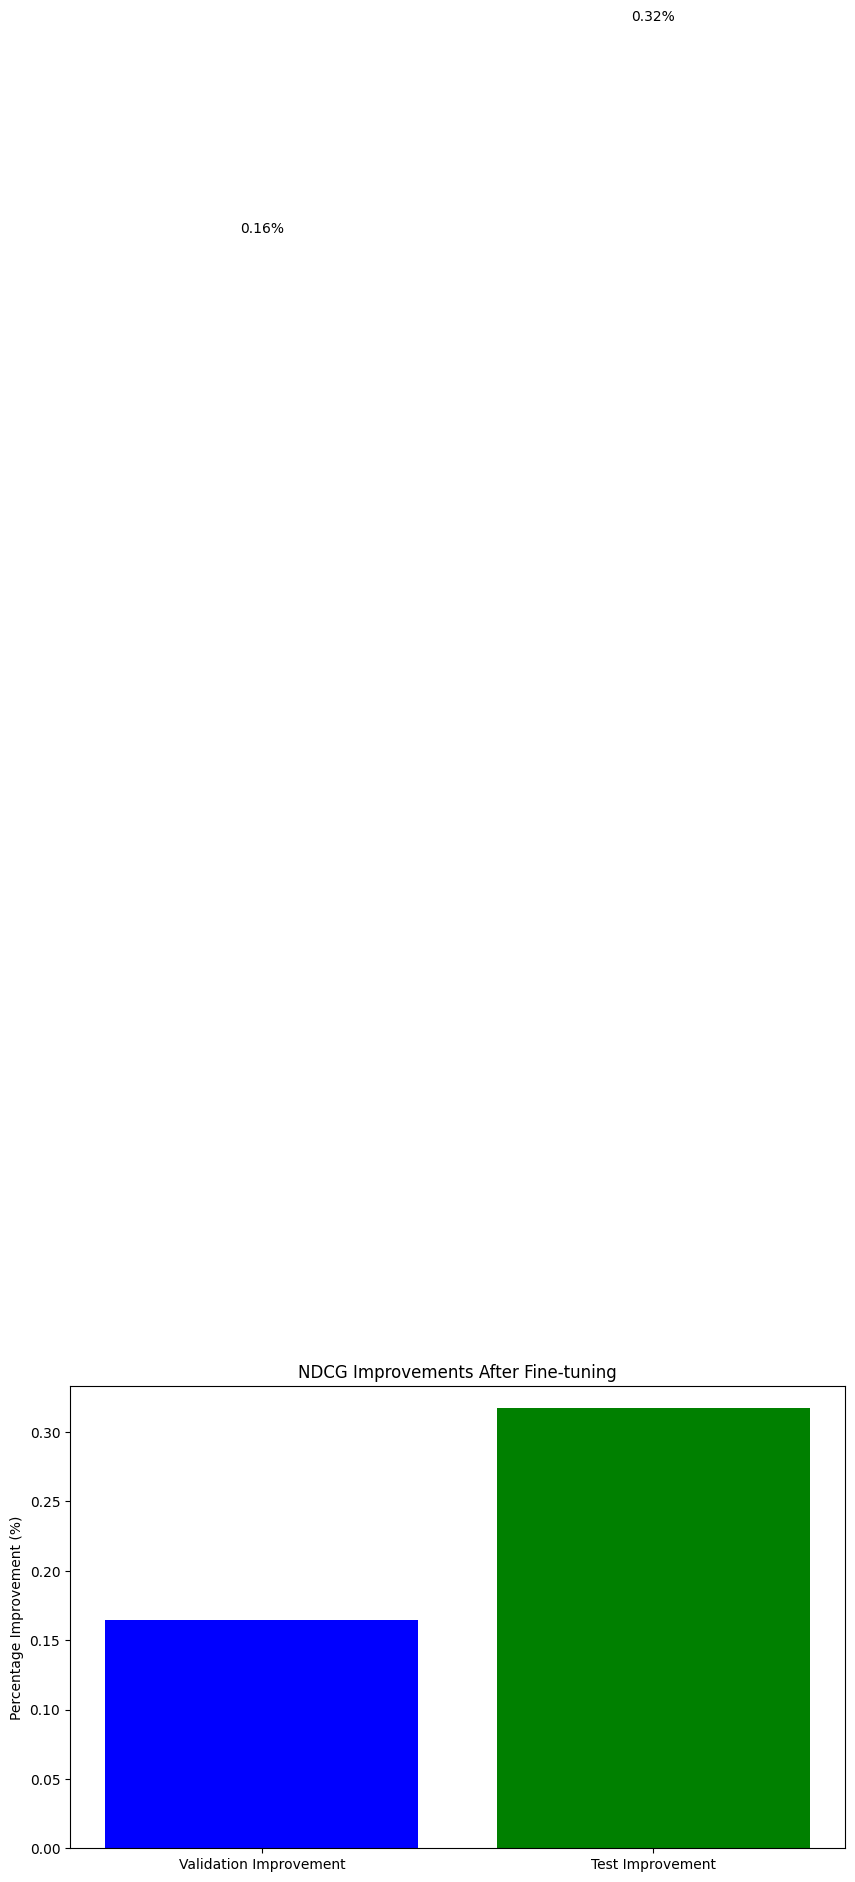


Improvement comparison chart saved as 'embedding_improvement.png'


In [10]:


test_improvement = fine_tuned_test_ndcg - base_test_ndcg
test_improvement_percent = (test_improvement / base_test_ndcg) * 100 if base_test_ndcg > 0 else 0

print(f"\nTest Set {ndcg_key} Improvement: {test_improvement:.4f} (absolute) / {test_improvement_percent:.2f}% (relative)")

# Create visualization for test improvements
plt.figure(figsize=(10, 6))
plt.bar(['Validation Improvement', 'Test Improvement'], 
        [improvement_percent, test_improvement_percent], 
        color=['blue', 'green'])
plt.ylabel('Percentage Improvement (%)')
plt.title('NDCG Improvements After Fine-tuning')

# Add the actual values on top of the bars
for i, v in enumerate([improvement_percent, test_improvement_percent]):
    plt.text(i, max(v+1, 1), f"{v:.2f}%", ha='center')

# plt.tight_layout()
plt.show()

print("\nImprovement comparison chart saved as 'embedding_improvement.png'")
